## SSAC - Exploration 5 - Speech Recognition

1. 데이터 처리와 분류

    라벨 데이터 처리하기
    sklearn의 train_test_split함수를 이용하여 train, test 분리

2. 학습을 위한 하이퍼파라미터 설정
3. 데이터셋 구성

    tf.data.Dataset을 이용
    from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용
    map과 batch를 이용한 데이터 전처리
    주의 : waveform을 spectrogram으로 변환하기 위해 추가로 사용하는 메모리 때문에 이후 메모리 부족 현상을 겪게 될수도 있습니다.
    tf.data.Dataset이 생성된 이후, 아래 예시와 같이 wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워 주면 도움이 됩니다.   
    
```{python}
del speech_data
del spec_data
```   
   
4. 2차원 Spectrogram 데이터를 처리하는 모델 구성

    2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능
    batchnorm, dropout, dense layer 등을 이용
    12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용
    모델 가중치를 저장하는 checkpoint callback 함수 추가
    다양한 모델의 실험을 진행해 보시기 바랍니다.

5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력

    loss, accuracy를 그래프로 표현

6. Test dataset을 이용해서 모델의 성능을 평가

    저장한 weight 불러오기
    모델의 예측값과 정답값이 얼마나 일치하는지 확인

In [1]:
# import required packages
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os, random, librosa, time
import IPython.display as ipd
import librosa.display
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tqdm import tqdm

In [2]:
# load data
data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

In [3]:
# data shape
print(f'Wave data shape :  {speech_data["wav_vals"].shape}')
print(f'Label data shape :  {speech_data["label_vals"].shape}')

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [4]:
# check loaded data
rand = random.randint(0, len(speech_data["wav_vals"]))
print(f"rand num : {rand}")

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print(f"Wave data shape :  {data.shape}")
print(f"label :  {speech_data['label_vals'][rand]}")

ipd.Audio(data, rate=sr)

rand num : 24256
Wave data shape :  (8000,)
label :  ['go']


In [5]:
# look into dataset
type(speech_data)

numpy.lib.npyio.NpzFile

In [6]:
dir(speech_data)

['__abstractmethods__',
 '__class__',
 '__contains__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_files',
 'allow_pickle',
 'close',
 'f',
 'fid',
 'files',
 'get',
 'items',
 'iteritems',
 'iterkeys',
 'keys',
 'pickle_kwargs',
 'values',
 'zip']

In [7]:
speech_data.files

['wav_vals', 'label_vals']

## 1-1. convert labels in string to integer

In [8]:
sample = []
for i in range(3):
    idx = random.randint(0, len(speech_data['label_vals']))
    sample.append(idx)
for i in sample:
    print(speech_data['label_vals'][i])

['silence']
['left']
['on']


In [9]:
# gather label data 
labels = []
for label in speech_data['label_vals']:
    if label not in labels:
        labels.append(label)
labels

[array(['down'], dtype='<U7'),
 array(['go'], dtype='<U7'),
 array(['left'], dtype='<U7'),
 array(['no'], dtype='<U7'),
 array(['off'], dtype='<U7'),
 array(['on'], dtype='<U7'),
 array(['right'], dtype='<U7'),
 array(['stop'], dtype='<U7'),
 array(['up'], dtype='<U7'),
 array(['yes'], dtype='<U7'),
 array(['unknown'], dtype='<U7'),
 array(['silence'], dtype='<U7')]

In [10]:
import re
target_list = []
for label in labels:
    label = str(label)
    label = re.sub('[^a-z]','',label)
    target_list.append(label)
target_list

['down',
 'go',
 'left',
 'no',
 'off',
 'on',
 'right',
 'stop',
 'up',
 'yes',
 'unknown',
 'silence']

In [11]:
# make dictionary ; assign integers to labels
label_value = { s : i for i, s in enumerate(target_list) }
print(f'Indexed LABEL : {label_value}')

Indexed LABEL : {'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'up': 8, 'yes': 9, 'unknown': 10, 'silence': 11}


In [12]:
# replace labels in dataset with assinged integer
temp = []
for string_label in speech_data['label_vals']:
    temp.append(label_value[string_label[0]])
label_data = np.array(temp)
label_data

array([ 0,  0,  0, ..., 11, 11, 11])

## 1-2. spectrogram conversion

In [13]:
def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

In [14]:
sample = speech_data['wav_vals'][0]
start = time.time()
spec = wav2spec(sample)
print("Waveform shape : ", sample.shape)
print("Spectrogram shape : ", spec.shape)
print(f'time : {time.time() - start}')

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)
time : 0.0012135505676269531


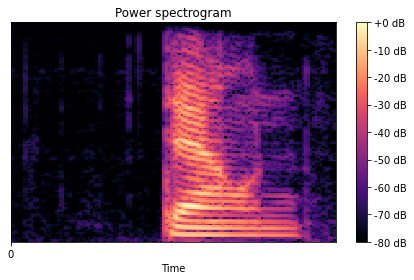

In [15]:
librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

In [16]:
del sample

---

+ spectrogram conversion

In [17]:
speech_data['wav_vals'].shape

(50620, 8000)

In [18]:
start = time.time()
spec_data=[]
for wav in tqdm(speech_data['wav_vals']):
    stft = wav2spec(wav)
    spec_data.append(stft)
spec_data = np.array(spec_data)
spec_data.shape
print(f'time : {time.time() - start}')

100%|██████████| 50620/50620 [00:38<00:00, 1307.66it/s]


time : 42.64873170852661


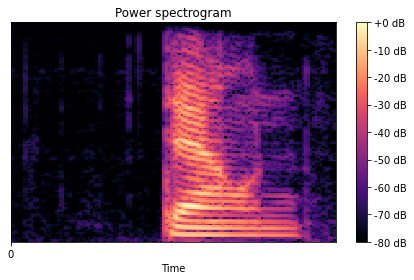

In [19]:
librosa.display.specshow(librosa.amplitude_to_db(spec_data[0], ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

In [20]:
del speech_data

## 1-3. data split

In [21]:
# data split

train_spec, test_spec, train_label, test_label = train_test_split(spec_data, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                random_state=7,
                                                                shuffle=True)
print(train_spec)

print(f'train data : {train_spec.shape}')
print(f'train labels : {train_label.shape}')
print(f'test data : {test_spec.shape}')
print(f'test labels : {test_label.shape}')

[[[1.28467642e-02 5.69626503e-03 1.13709888e-03 ... 4.16167226e-04
   4.56441334e-03 1.12375878e-02]
  [1.70485321e-02 8.07855092e-03 2.21799617e-03 ... 3.32283508e-03
   7.67117552e-03 1.17295459e-02]
  [2.18634121e-02 1.46937771e-02 3.84549308e-03 ... 8.18202924e-03
   5.52943721e-03 1.20183639e-02]
  ...
  [4.58302163e-03 2.02101469e-03 5.64236951e-04 ... 5.85821690e-04
   2.44899862e-03 4.53280937e-03]
  [4.53532441e-03 2.42813444e-03 7.45598372e-05 ... 1.81945026e-04
   2.58287042e-03 4.81946347e-03]
  [4.60953871e-03 2.27410300e-03 5.53887548e-05 ... 5.73362304e-05
   2.34686537e-03 4.70350543e-03]]

 [[3.58626537e-04 3.33464704e-04 2.36538021e-04 ... 4.95152723e-04
   6.19869633e-03 1.24919927e-02]
  [1.30108718e-04 2.39492714e-04 9.47077351e-05 ... 2.03335914e-03
   6.97439443e-03 1.46333547e-02]
  [2.06850294e-04 1.52561028e-04 5.86182468e-05 ... 1.58155418e-03
   1.19672166e-02 1.94252096e-02]
  ...
  [1.41437852e-06 3.80224310e-06 5.11041435e-06 ... 7.22041977e-06
   6.03681

In [22]:
del spec_data

## 2. set hyperparameters

In [23]:
# set hyper paremeters
batch_size = 32
max_epochs = 10

## 3. preprocess with tensorflow, build tensorflow input pipeline

In [24]:
# tensorflow.one_hot : make one-hot encoding
tf.one_hot([0,5,11], depth=12) # takes in indices and return one-hot ecoded input indices.; value 1 in first, sixth, twelvth in row 1, 2, 3 respectively.

<tf.Tensor: shape=(3, 12), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)>

In [25]:
def one_hot_label(spec, label):
    label = tf.one_hot(label, depth=12) # 0 ~ 11 label
    return spec, label

In [26]:
# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>


## 4-1. build model takes in spectrogram data : conv1d layer

In [27]:
input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec = tf.keras.Model(input_tensor, output_tensor)

model_spec.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 130, 32)           36320     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 130, 32)           9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 65, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65, 64)            18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 65, 64)            36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 64)            0     

In [28]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [29]:
# assign save point directory
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/e5_spectogram_1d'
checkpoint_dir

'/home/ssac7/aiffel/speech_recognition/models/e5_spectogram_1d'

In [30]:
# callback to save weights with lowest validation loss
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [31]:
history_spec = model_spec.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 1.4364 - accuracy: 0.5087
Epoch 00001: val_loss improved from inf to 0.88821, saving model to /home/ssac7/aiffel/speech_recognition/models/e5_spectogram_1d
1423/1423 [==============================] - 11s 8ms/step - loss: 1.4364 - accuracy: 0.5087 - val_loss: 0.8882 - val_accuracy: 0.6920
Epoch 2/10
1417/1423 [============================>.] - ETA: 0s - loss: 0.7150 - accuracy: 0.7600
Epoch 00002: val_loss improved from 0.88821 to 0.58565, saving model to /home/ssac7/aiffel/speech_recognition/models/e5_spectogram_1d
1423/1423 [==============================] - 11s 7ms/step - loss: 0.7143 - accuracy: 0.7601 - val_loss: 0.5856 - val_accuracy: 0.8018
Epoch 3/10
1419/1423 [============================>.] - ETA: 0s - loss: 0.4712 - accuracy: 0.8428
Epoch 00003: val_loss improved from 0.58565 to 0.44308, saving model to /home/ssac7/aiffel/speech_recognition/models/e5_spectogram_1d
1423/1423 [=============================

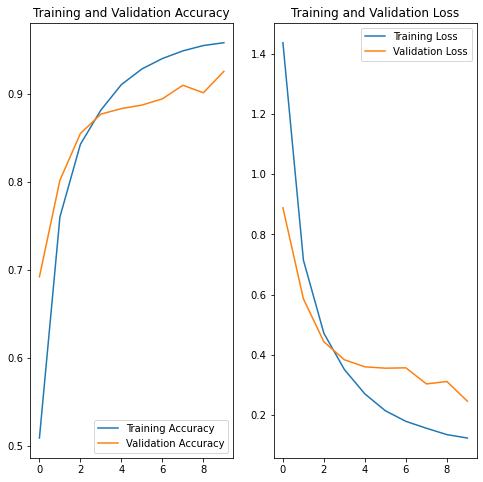

In [32]:
# trainig porgress plot
acc = history_spec.history['accuracy']
val_acc = history_spec.history['val_accuracy']

loss=history_spec.history['loss']
val_loss=history_spec.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
# evalueate model with test dataset
model_spec.load_weights(checkpoint_dir)
results = model_spec.evaluate(test_dataset)
# loss
print(f"loss value: {results[0]:.3f}")
# accuracy
print(f"accuracy value: {results[1]*100:.4f}")

159/159 [==============================] - 27s 170ms/step - loss: 0.2455 - accuracy: 0.9257
loss value: 0.246
accuracy value: 92.5721


In [34]:
inv_label_value = {v: k for k, v in label_value.items()}

In [35]:
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_spec(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))
print(f'prediction : {inv_label_value[np.argmax(y_pred_)]}')

label :  unknown
prediction : unknown


---

## 4-2 build model takes in spectogram data : conv2d

In [36]:
input_tensor = layers.Input(shape=(130, 126, 1)) # spectrogram image size shape

x = layers.Conv2D(32, (5,5), padding='same', activation='relu')(input_tensor) # smae padding, 32 conv2d filter size 5x5
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, (5,5), padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(326, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(326, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec = tf.keras.Model(input_tensor, output_tensor)

model_spec.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 65, 63, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 31, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 31, 128)       1475

In [37]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [38]:
# assign save point directory
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/e5_spectogram_2d'
checkpoint_dir

'/home/ssac7/aiffel/speech_recognition/models/e5_spectogram_2d'

In [39]:
# callback to save weights with lowest validation loss
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [40]:
history_spec = model_spec.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 0.8203 - accuracy: 0.7418
Epoch 00001: val_loss improved from inf to 0.34943, saving model to /home/ssac7/aiffel/speech_recognition/models/e5_spectogram_2d
1423/1423 [==============================] - 40s 28ms/step - loss: 0.8203 - accuracy: 0.7418 - val_loss: 0.3494 - val_accuracy: 0.8849
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.2951 - accuracy: 0.9099
Epoch 00002: val_loss improved from 0.34943 to 0.22298, saving model to /home/ssac7/aiffel/speech_recognition/models/e5_spectogram_2d
1423/1423 [==============================] - 40s 28ms/step - loss: 0.2951 - accuracy: 0.9099 - val_loss: 0.2230 - val_accuracy: 0.9258
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.1884 - accuracy: 0.9433
Epoch 00003: val_loss improved from 0.22298 to 0.17208, saving model to /home/ssac7/aiffel/speech_recognition/models/e5_spectogram_2d
1423/1423 [===========================

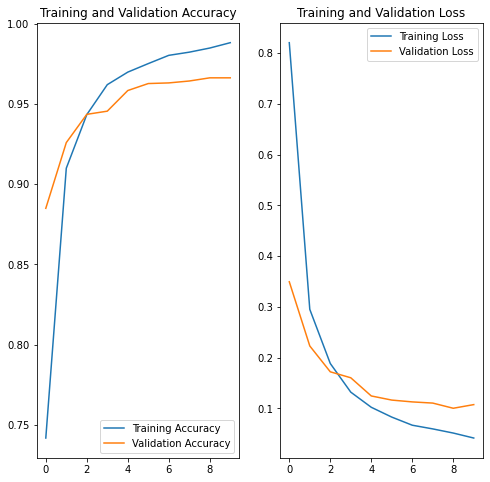

In [41]:
# trainig porgress plot
acc = history_spec.history['accuracy']
val_acc = history_spec.history['val_accuracy']

loss=history_spec.history['loss']
val_loss=history_spec.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [42]:
# evalueate trained model with test dataset
model_spec.load_weights(checkpoint_dir)
results = model_spec.evaluate(test_dataset)
# loss
print(f"loss value: {results[0]:.3f}")
# accuracy
print(f"accuracy value: {results[1]*100:.4f}")

159/159 [==============================] - 29s 180ms/step - loss: 0.1002 - accuracy: 0.9662
loss value: 0.100
accuracy value: 96.6219


+ number of the parameters of the second model is more than doubled fromt the first.
+ second shows better accuracy in test set.

In [43]:
inv_label_value = {v: k for k, v in label_value.items()}

In [44]:
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_spec(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))
print(f'prediction : {inv_label_value[np.argmax(y_pred_)]}')

label :  off
prediction : off


---

## 4-2 build model takes in spectogram data : conv2d with skip connection

In [46]:
input_tensor = layers.Input(shape=(130, 126, 1)) # spectrogram image size shape

x = layers.Conv2D(32, (5,5), padding='same', activation='relu')(input_tensor) # smae padding, 32 conv2d filter size 5x5
skip_1 = layers.MaxPool2D()(x)

x = layers.Conv2D(64, (5,5), padding='same', activation='relu')(skip_1) # takes skip_1 layer output as input
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D()(x)

x = layers.Conv2D(326, (3,3), padding='same', activation='relu')(skip_3)
x = layers.Conv2D(326, (3,3), padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec = tf.keras.Model(input_tensor, output_tensor)

model_spec.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 130, 126, 32) 832         input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 65, 63, 32)   0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 65, 63, 64)   51264       max_pooling2d_5[0][0]            
____________________________________________________________________________________________

In [47]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [48]:
# assign save point directory
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/e5_spectogram_2d_skip'
checkpoint_dir

'/home/ssac7/aiffel/speech_recognition/models/e5_spectogram_2d_skip'

In [49]:
# callback to save weights with lowest validation loss
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [50]:
history_spec = model_spec.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 0.8931 - accuracy: 0.7190
Epoch 00001: val_loss improved from inf to 0.40673, saving model to /home/ssac7/aiffel/speech_recognition/models/e5_spectogram_2d_skip
1423/1423 [==============================] - 47s 33ms/step - loss: 0.8931 - accuracy: 0.7190 - val_loss: 0.4067 - val_accuracy: 0.8693
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.3218 - accuracy: 0.9011
Epoch 00002: val_loss improved from 0.40673 to 0.24761, saving model to /home/ssac7/aiffel/speech_recognition/models/e5_spectogram_2d_skip
1423/1423 [==============================] - 47s 33ms/step - loss: 0.3218 - accuracy: 0.9011 - val_loss: 0.2476 - val_accuracy: 0.9244
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.2070 - accuracy: 0.9374
Epoch 00003: val_loss improved from 0.24761 to 0.19853, saving model to /home/ssac7/aiffel/speech_recognition/models/e5_spectogram_2d_skip
1423/1423 [============

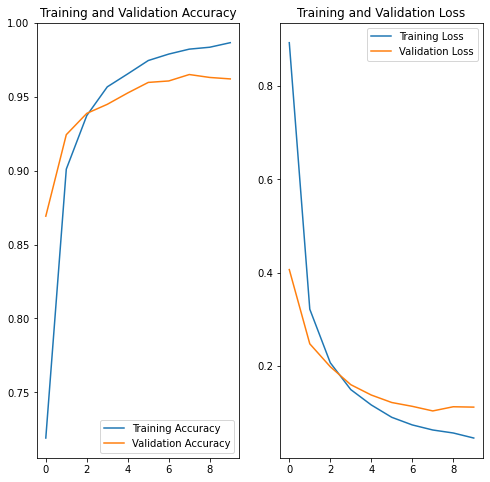

In [51]:
# trainig progress plot
acc = history_spec.history['accuracy']
val_acc = history_spec.history['val_accuracy']

loss=history_spec.history['loss']
val_loss=history_spec.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [52]:
# evalueate trained model with test dataset
model_spec.load_weights(checkpoint_dir)
results = model_spec.evaluate(test_dataset)
# loss
print(f"loss value: {results[0]:.3f}")
# accuracy
print(f"accuracy value: {results[1]*100:.4f}")

159/159 [==============================] - 12s 73ms/step - loss: 0.1036 - accuracy: 0.9652
loss value: 0.104
accuracy value: 96.5231


+ conv2d with skip connection has more paramters than 2nd model and yet shows lower accuracy in test dataset.
   + 2nd model does not seem to be overfitted; skip connection may not be affective here.
   + rather 3rd model shows hint of rise in validation loss as training epoch advances.

In [53]:
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_spec(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))
print(f'prediction : {inv_label_value[np.argmax(y_pred_)]}')

label :  on
prediction : on


---